# 1 часть модели, способная предсказывать необходимый параметр по SMILES.
**Примечание:** Количество SMILES для одного масла может быть произвольным;

In [1]:
import deepchem as dc
import polars as pl
import pandas as pd
import numpy as np

from rdkit import Chem, RDLogger

from typing import Optional

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer


def read(n: str, **kwargs):
    return pl.read_csv(f"../data/{n}", **kwargs).to_pandas()


RDLogger.DisableLog("rdApp.*")

public = read("public/data.csv")
check = read("public/check.csv")
check = check.drop_duplicates(subset=["blend_id"]).reset_index(drop=True)

Skipped loading some Pytorch utilities, missing a dependency. No module named 'torch'


This module requires PyTorch to be installed.


No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!



Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


Skipped loading some PyTorch models, missing a dependency. No module named 'torch'
No module named 'torch'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch'
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'torch'
Skipped loading some Jax models, missing a dependency. No module named 'jax'


In [2]:
featurizer = dc.feat.CircularFingerprint(size=1024)


def preprocess(
    data: pd.DataFrame, preprocessor: Optional[ColumnTransformer] = None
) -> tuple[pd.DataFrame, Optional[pd.DataFrame], Optional[ColumnTransformer]]:
    data = data.copy()
    data.dropna(subset=["smiles"], inplace=True)

    def compute_descriptors(smiles: str):
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None

        feature = featurizer.featurize([mol])[0]
        if feature is None:
            feature = np.zeros(featurizer.size)

        features = {}

        for i, bit in enumerate(feature):
            features[f"CFin_{i}"] = bit

        return features

    descriptors_df = pd.DataFrame.from_records(
        data.smiles.apply(compute_descriptors).dropna()
    )
    data = pd.concat([data, descriptors_df], axis=1)
    data = data.drop("smiles", axis=1)

    data.dropna(subset=["blend_id"], inplace=True)
    categorical_cols = ["blend_id"]
    if (
        preprocessor is None
        and len(data.select_dtypes(include=["object", "category"]).columns) > 0
    ):
        categorical_transformer = Pipeline(
            steps=[
                (
                    "imputer",
                    SimpleImputer(strategy="constant", fill_value="missing"),
                ),
                ("onehot", OneHotEncoder(handle_unknown="ignore")),
            ]
        )
        preprocessor = ColumnTransformer(
            transformers=[
                ("cat", categorical_transformer, categorical_cols),
            ],
            remainder="passthrough",
        )

        encoding_data = pd.DataFrame(
            preprocessor.fit_transform(data[categorical_cols]).toarray(),
            columns=preprocessor.get_feature_names_out(categorical_cols),
        )
        data = pd.concat([data, encoding_data], axis=1)
        data = data.drop(categorical_cols, axis=1)
    else:
        encoding_data = pd.DataFrame(
            preprocessor.transform(data[categorical_cols]).toarray(),
            columns=preprocessor.get_feature_names_out(categorical_cols),
        )
        data = pd.concat([data, encoding_data], axis=1)
        data = data.drop(categorical_cols, axis=1)

    data.dropna(inplace=True)

    if "oil_property_param_value" in data.columns:
        y = data.pop("oil_property_param_value")
        return pd.DataFrame(data), pd.DataFrame(y), preprocessor

    return pd.DataFrame(data), None, preprocessor


X, y, preprocessor = preprocess(public)
X.head(1)

,CFin_0,CFin_1,CFin_2,CFin_3,CFin_4,CFin_5,CFin_6,CFin_7,CFin_8,CFin_9,...,cat__blend_id_f9a8223a-0cf1-11ed-87b0-005056921581,cat__blend_id_fb57b4fe-632f-11ec-8eb2-005056921581,cat__blend_id_fb583e86-4de6-11ed-9a6d-005056921581,cat__blend_id_fbc44952-0f2d-11ed-9900-005056921581,cat__blend_id_fc68e5c8-b25f-11ec-8ff7-005056921581,cat__blend_id_fd893206-5e3a-11ec-803b-005056921581,cat__blend_id_fd96a6a2-b0fb-11ec-9d4e-005056921581,cat__blend_id_fe2c1c0a-4f84-11ed-93f9-005056921581,cat__blend_id_fe497da4-4ac5-11ed-8f31-005056921581,cat__blend_id_fe8635a0-1262-11ed-8f47-005056921581
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
dataset = dc.data.NumpyDataset(X=X, y=y.oil_property_param_value.to_numpy())

splitter = dc.splits.RandomSplitter()
train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(
    dataset=dataset, frac_train=0.6, frac_valid=0.2, frac_test=0.2
)

In [4]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
model = dc.models.SklearnModel(model=rf)

# Model training
model.fit(train_dataset)

In [5]:
# initialze the metric
metric = dc.metrics.Metric(dc.metrics.mae_score)

# evaluate the model
valid_score = model.evaluate(valid_dataset, [metric])["mae_score"]
test_score = model.evaluate(test_dataset, [metric])["mae_score"]

print(f"Valid score: {valid_score:.2f}, Test score: {test_score:.2f}")

Valid score: 38240.37, Test score: 40049.52


In [21]:
X_check, _, _ = preprocess(check, preprocessor)
X_check_dataset = dc.data.NumpyDataset(X=X_check)

predictions = pd.DataFrame(model.predict(X_check_dataset), columns=["results"])
predictions = pd.concat([check.blend_id, predictions], axis=1)
predictions.head(1)

,blend_id,results
0,d272c9a6-3332-11ed-9685-005056921581,26494.53


In [22]:
predictions.to_csv("../predictions.csv", index=False)

In [34]:
!7z a ../solution.zip random_forest-smiles2target.ipynb ../predictions.csv


7-Zip 23.01 (x64) : Copyright (c) 1999-2023 Igor Pavlov : 2023-06-20

Scanning the drive:
2 files, 20814 bytes (21 KiB)

Creating archive: ../solution.zip

Add new data to archive: 2 files, 20814 bytes (21 KiB)


Files read from disk: 2
Archive size: 5308 bytes (6 KiB)
Everything is Ok


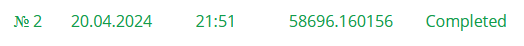